In [1]:
"""
################################################################################################################################

This is a mini project to seek the optimized execution method on stocks.
Simulate the stock path with geometric brownian motion. 
Compare the execution performance vs average price.
Further work is to extend this into a trade simulator that has players placing active and passive orders, whereas the execution
algo has to hit the bid/ask or place limit orders.

################################################################################################################################
"""

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Part 1
# Function that generate stock path

def stock_path_generator(r, sigma, T, N, steps, S0=100, seed=1):  # N: number of paths, steps:number of steps of each path
    """
    input: 
    r: interest rate
    sigma: volatility
    T: total time
    """
    dt = float(T)/steps
    paths = np.zeros((steps+1, N), np.float64)
    paths[0] = S0
    np.random.seed(seed)
    for i in range(1, steps+1):
        rand = np.random.standard_normal(N)
        paths[i] = paths[i-1] * np.exp((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*rand)
    return paths

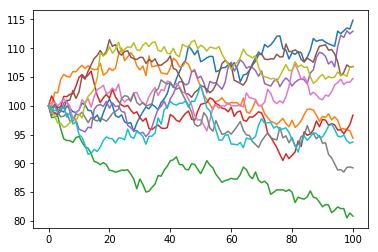

In [3]:
"""sample use of the path generator"""
r = .05
sigma = .1
T = 1
N = 10
steps = 100
sample_paths = stock_path_generator(r, sigma, T, N, steps, S0=100, seed = 1)
plt.plot(sample_paths)
plt.show()
#np.log(sample_paths[-500].mean()/100)
#a = sample_paths[:,1]
#b = np.diff(np.log(a))


In [16]:
# Part 2
# Trade execution algo, given amount to buy, and time to buy within

# 2.1 Estimating the parameters of the stock path

def estimate_params(path):
    steps = path.shape[0]-1
    log_returns = np.diff(np.log(path))
    mu = sum(log_returns)/steps                     # mu = (r-0.5*sigma^2)*dt
    v = sum(np.square(log_returns-mu))/steps        # v = sigma^2*dt
    return mu, v

In [47]:
# 2.2.1 Simplest case: can only send order once, if not executed buy it at the end price of the time window

def buy_once_algo(path, t, n):
    mu, v = estimate_params(path)
    limit_order_price = path[-1] + mu*t - n*np.sqrt(t)*np.sqrt(v)*path[-1]
    return limit_order_price
    
def trade_price(path, price):
    for p in path:
        if p <= price:
            return p
    return path[-1]

def avg_price(path):
    return np.mean(path)

def split_path(path, train_ratio):
    split_point = int(path.shape[0]*train_ratio)
    return path[:split_point], path[split_point:]

In [41]:
path = sample_paths[:,0]
T = path.shape[0]
observed_path = path[:int(T/2)]
live_path = path[int(T/2):]

limit_price = buy_once_algo(observed_path, int(T/2), 1)
actual_trade_price = trade_price(live_path, limit_price)
benchmark = avg_price(live_path)

execution_score = (benchmark-actual_trade_price)/benchmark
print(limit_price, actual_trade_price, benchmark, execution_score)

102.10461508857048 114.86422767087248 109.3144404691649 -0.050769021712854634


In [56]:
#finding best parameter

ns = np.linspace(-2,2,100)
exe_scores = []

r = .05
sigma = .1
T = 1
N = 1000
steps = 100
train_ratio = .5
stock_paths = stock_path_generator(r, sigma, T, N, steps, S0=100, seed = 1)

for n in ns:
    exe_score = []
    for i in range(N):
        path = stock_paths[:, i]
        train, test = split_path(path, train_ratio)
        limit_price = buy_once_algo(train, int(steps*(1-train_ratio)), n)
        actual_trade_price = trade_price(test, limit_price)
        benchmark = avg_price(test)
        execution_score = (benchmark-actual_trade_price)/benchmark
        exe_score.append(execution_score)
    exe_scores.append(np.mean(exe_score))

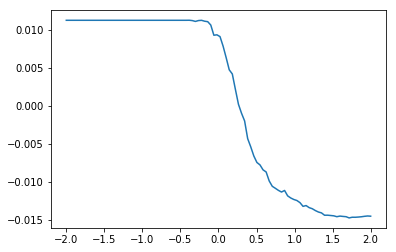

In [58]:
plt.plot(ns, exe_scores)

In [ ]:
# Conclusion: for the simple trade execution algo, if trend is upwards, its better off buy the stock at the beginning
# further research can be done by varying the total quantity to trade, and modelling the market impact of the trade execution
# this will need some deep learning knowledge. Will revisit later. as of 3/7/2019